# PHYS 210 Mini-Project 03

### Ferromagneticsm

Due Wed, Nov 23, 2022 - 9am


#### Project objective

Explore the Curie temperature and the Ising model of Ferromagnetism

#### Before getting started

- Read the Mini-Project 03 background handout in the same folder as this notebook. It provides all the details.


In [1]:
# Main code here - generate plots and animations in individual cells below.
# YOUR CODE HERE
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import copy

"""
This project works by creating a State class that stores the relevant attributes of the system.
The state object is time stepped with the timestep() function, and the main array can be accessed
with state.arr
The main optimization made was in the calculation of h(arr). Rather than recalculate H(arr) by iterating
through the entire array every time, the contribution of each individual cell can be accessed with the Hat(i,j)
function, and this function is used in the updateH() function within timestep() to update the H value every time
a random flip is generated. 

New Code features: 
    Object orientation: The state object stores the state of the system, and can be manipulated with built-in methods

Extension: 
    3d adaptation of isling model, interacting 3d plot of the end result.
"""


# Initial Variables
# Size of array generated
x = 50
y = 50

# Main state object definition
class State:
    """
    State is the object that stores the state of system. It has the following variables:
    x: x length of the array, int
    y: y lengths of the array, int
    t: temperature of the state, float
    arr: the state array, 2d numpy array of size(x, y)
    h: the H value of system

    State has the following methods:
    State(x,y,t)/__init__(x,y,t): creates State object 
        all arguments optional

    genarr(x, y): generates random array of size x, y
        all arguments optional
    
    H(): Completely calculates H value and updates self.h from scratch and returns new h value 

    Hat(i, j): returns the contribution of position arr[i, j] to h sum.

    updateH(i, j): updates H value to new array, assumes array has already been modified

    M(): returns M(arr)

    get_randM(n): returns M value of random array after n steps

    timestep(): calculates new state of self after 1 timestep and updates self object

    randomize(): generates new random values for arr and calculates new H(arr)
    """

    def __init__(self, x=50, y=50, t=1) -> None:
        """
        Constructor used when initializing State object, generates
        new random array of size x, y and calculates an H value for self
        """
        self.x = x
        self.y = y
        self.t = t
        self.arr = self.genarr(x, y)
        self.h = self.H()
        pass

    def genarr(self, x=50, y=50):
        """
        Generates new random array of dimension (self.x,self.y)
        """
        arr = np.random.rand(x, y)
        for i in range(x):
            for j in range(y):
                if arr[i, j] < 0.5:
                    arr[i, j] = -1
                else:
                    arr[i, j] = 1

        return arr

    def Hat(self, i, j):
        """
        return H value of summation at i, j
        """
        return (-1/2)*self.arr[i, j]*(self.arr[i-1, j] +
                                      self.arr[i, j-1] +
                                      self.arr[(i+1) % x, j] +
                                      self.arr[i, (j+1) % y])

    def updateH(self, i, j):
        """
        Assumes array has already been flipped in timestep. Uses i and j
        as the flipped location, and changes H by the updated value at that location
        rather than recalculating H from scratch.
        returns None
        """
        # add new h(i,j) to self.h sum
        self.h += self.Hat(i, j)
        # flip to other arr
        self.arr[i, j] *= -1
        # get rid of old h(i,j) from sum
        self.h -= self.Hat(i, j)
        # flip back to new value
        self.arr[i, j] *= -1

    def H(self):
        """
        completely calculates new value of H(self.arr), should only be used when
        initially generating H in the constructor.
        
        returns h value calculated
        """
        sum = 0
        for i in range(x):
            for j in range(y):
                sum += self.Hat(i,j)
        self.h = (-1/2)*sum
        return self.h

    def M(self):
        """
        Sums over self.arr and divides by len of elements in array
        returns float
        """
        return np.sum(self.arr)/(self.x*self.y)

    def get_randM(self, n):
        """
        Makes a random value of M, with n timesteps. Loops over timestep() n times
        updates self
        returns float
        """

        # Make self.arr a randomly generated array
        self.arr = self.genarr()

        # Main loop
        for i in range(n):
            self.timestep()

        # Returns the M(self)
        return copy.deepcopy(self.M())

    def timestep(self):
        """
        Steps time. initially generates random coordinates, then stores old value of h
        then flips array to new possible state, and updates h. Compares the two and keeps
        the new h and arr values if energy goes down, or if a probability value is higher than
        a random float generated. 
        
        Updates self
        Returns None
        """
        # Generating random electron index to flip
        randx = np.random.randint(0, x)
        randy = np.random.randint(0, y)

        # Deep copy so that the value itself is stored in h1 rather than a reference
        h1 = copy.deepcopy(self.h)

        # Now flipping the spin at that state
        self.arr[randx, randy] *= -1

        # Updates H so now, self can be considered the new possible state
        self.updateH(randx, randy)

        # checking if h1 is bigger than new value of h
        if h1 >= self.h:
            # Keep new values
            return

        # Since h1 is not bigger, generate chance that new state is kept anyways
        diceroll = np.exp(-(self.h-h1)/self.t)

        if np.random.rand() < diceroll:
            # Keep new values
            return

        # Keep old values, flip arr[rand,randy] back to the old value
        self.arr[randx, randy] *= -1
        # revert to previous H
        self.updateH(randx, randy)

        return

    def randomize(self):
        """
        Randomizes state of arr and calculates new H(arr)
        updates self
        returns None
        """
        self.arr = self.genarr(self.x, self.y)
        self.h = self.H()


def makevideo(t, steps=600000, frames=2000, name="timelapse.webm"):
    """
    Makes video of a random array at temperature t, after steps steps,
    making a frame every frames frames and names the video name.

    returns none, stores video on disk at ./name
    """

    fig = plt.figure()  # Create a new figure
    ims = []  # List to store our grids of random numbers
    state = State(x, y, t) # Generate state object

    for i in range(steps): # Main loop
        state.timestep() # step

        if i % frames == 0: # Check if making frame or not
            ims.append((plt.pcolormesh(state.arr), ))

    imani = animation.ArtistAnimation(
        fig,  # Not used here, but would be needed for resizing, etc
        ims,  # The list to animate
        interval=60,  # Time between frames in ms
        repeat=False,  # Repeat not used here. Useful in later projects
    )
    # Save file
    imani.save(name, extra_args=['-vcodec', 'libvpx'])
    plt.close()  # Prevents a stray plot from appearing

    del ims  # Release crucial Cocal memory related to these objects
    del imani  #


In [2]:
def maxM(t, n=5, steps = 600000):
    """
    maxM takes 1 argument t, temperature and generates n
    trials of the state array of steps number of timesteps

    returns the maximum absolute value of M found
    """
    # Making temporary array to store m values
    marr = np.zeros(n)

    # Generate n values of M(sigma)
    for i in range(n):
        marr[i] = State(t=t).get_randM(steps)

    # Return max value
    return max(np.abs(marr))

[1.0, 1.0, 0.8144, 0.096, 0.044, 0.0504, 0.02, 0.036, 0.0232]


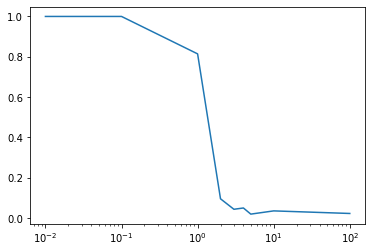

In [3]:
# Deliverable 1
# ~ 11 minutes
T = np.array([0.01, 0.1, 1, 2, 3, 4, 5, 10, 100])

lst = list(map(maxM, T))
print(lst)


plt.plot(T, lst)
plt.xscale("log")

In [4]:
# Zooming in on the phase transition
# # ~20 ish minutes
# T = np.linspace(.7, 2, 15)
# lst = list(map(maxM, T))
# print(lst)


# plt.plot(T, lst)
# plt.xscale("log")

In [5]:
# Deliverable 2
# Generate video for t = 0.01
makevideo(t=0.01, name="timelapse0.01.webm")

In [6]:
# Play video from storage
HTML('<video controls> <source src="timelapse0.01.webm" type="video/webm"> '
     '</video>')

In [7]:
# Generate video for t = 2.5
makevideo(t=2.5, steps=600000, name="timelapse2.5.webm")


In [8]:
# Play video from storage
HTML('<video controls> <source src="timelapse2.5.webm" type="video/webm"> '
     '</video>')

In [9]:
# Make video for t = 100
makevideo(t=100, steps=600000, name="timelapse100.webm")


In [10]:
# Play video from disk
HTML('<video controls> <source src="timelapse100.webm" type="video/webm"> '
     '</video>')

Also note that you can use the Format button while in a code cell to automagically fix most pep8 errors (other than way too long print statements)

![](project02-format.png)


In [11]:
# 3. Results (grader use only)


In [12]:
# 4. Readability (grader use only)


In [13]:
# 5. Plot (grader use only)


In [14]:
# Check execution time
nb_name = "project03.ipynb"
cells_to_time = []
stop_at = ['cell-extension']
%run - i time_cells2.py


Exception: File `'-.py'` not found.

In [ ]:
# 5. Code optimization/timing (grader use only)


In [ ]:
# B2. New Functionality/Language features (grader use only)
